In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
import toyplot
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

C:\Users\Alexander\Miniconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# fix a random seed
np.random.seed(12345)

# generate data for 199 years with higher rates before 1920
data = pd.DataFrame({
    "Frank_Sinatras_age": np.arange(0, 82),
    "Level_of_subjective_goodness_that_year": np.concatenate([
        np.random.poisson(10.0, 35),
        np.random.poisson(1.0, 47),
    ])
})

# introduce some random NaN values (pymc3 will handle these)
missing = np.random.randint(0, data.shape[0], 5)
data.loc[missing, "Level_of_subjective_goodness_that_year"] = np.nan

In [3]:
data.head()

,Frank_Sinatras_age,Level_of_subjective_goodness_that_year
0,0,16.0
1,1,7.0
2,2,11.0
3,3,18.0
4,4,12.0


In [4]:
# plot the generated data
toyplot.scatterplot(
    data.Frank_Sinatras_age,
    data.Level_of_subjective_goodness_that_year, 
    width=450, 
    height=300,
    size=8, 
    opacity=0.5,
    xlabel="age", 
    ylabel="goodness",
);

0 25 50 75 age 0 5 10 15 20 goodness

In [5]:
with pm.Model() as goodness_model:

    # sample switchpoint from within the bounds of our data timescale
    switchpoint = pm.DiscreteUniform(
        'switchpoint',
        lower=data.Frank_Sinatras_age.min(), 
        upper=data.Frank_Sinatras_age.max(), 
        testval=40)

    # Priors for pre- and post-switch rates for number of disasters
    early_rate = pm.Exponential('early_rate', 1.)
    late_rate = pm.Exponential('late_rate', 1.)

    # Allocate appropriate Poisson rates to years before and after current
    rate = pm.math.switch(switchpoint >= data.Frank_Sinatras_age, early_rate, late_rate)

    goodness = pm.Poisson('goodness', rate, observed=data.Level_of_subjective_goodness_that_year)

In [6]:
with goodness_model:
    trace = pm.sample(10000)

Assigned Metropolis to switchpoint
Assigned NUTS to early_rate_log__
Assigned NUTS to late_rate_log__
Assigned Metropolis to goodness_missing
100%|█████████▉| 10498/10500 [01:14<00:00, 141.18it/s]C:\Users\Alexander\Miniconda3\lib\site-packages\pymc3\step_methods\hmc\nuts.py:451: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.8801580159415718, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
100%|██████████| 10500/10500 [01:14<00:00, 141.14it/s]


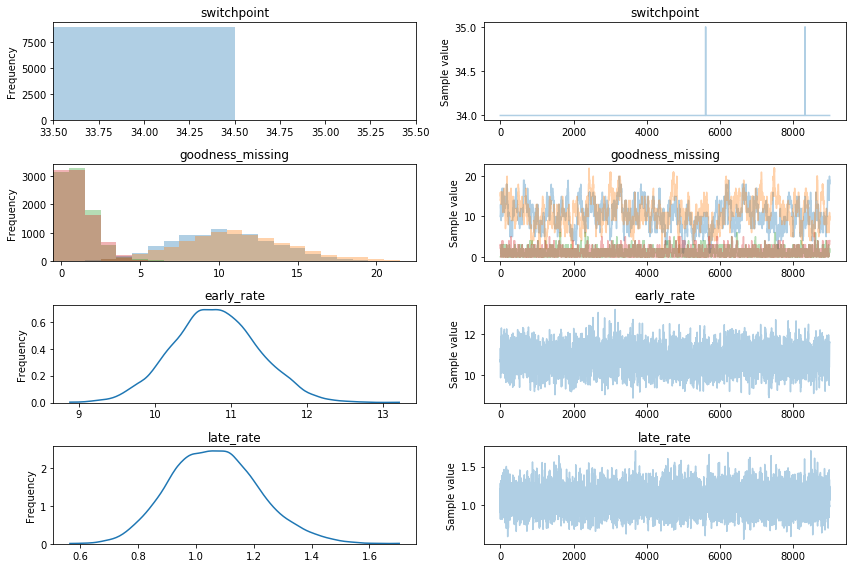

In [7]:
pm.traceplot(trace[1000:]);

In [8]:
pm.summary(trace)


switchpoint:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  34.001           0.030            0.001            [34.000, 34.000]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  34.000         34.000         34.000         34.000         34.000


goodness_missing:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  10.319           3.189            0.234            [4.000, 16.000]
  11.046           3.530            0.262            [5.000, 18.000]
  1.061            1.055            0.036            [0.000, 3.000]
  1.075            1.054            0.033            [0.000, 3.000]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |-------------

The model predicted the switchpoint fairly accurately; it detected an age of 34 as the time at which Frank Sinatra apparently stopped having good years. The true switchpoint of 35 was outside of the 95% HPD interval however.

Early and late rate values matched the input poisson loc fairly well, predicted ~11 and ~1 for true 10 and 1 respectively. 

The sampler took about 20-30 seconds to run. I did not encounter any problems running the model.